In [1]:
# imports
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from surprise import AlgoBase
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)

In [3]:
# read user events
user_events_file = 'dataset/explicit/BX-Book-Explicit-5Rate-Map.csv'
df_events = pd.read_csv(user_events_file, sep=',', encoding='ISO-8859–1')
print('No. of user events: ' + str(len(df_events)))

No. of user events: 88552


In [ ]:
scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('uid'):
    min_rating = group['rating'].min()
    max_rating = group['rating'].max()
    scaler = MinMaxScaler(feature_range=(1, 1000))
    scaled_ratings = scaler.fit_transform(group['rating'].values.reshape(-1, 1).astype(float))
    new_rows = group.copy()
    new_rows['rating'] = scaled_ratings
    scaled_df_events = scaled_df_events.append(new_rows)

scaled_df_events.head()

In [ ]:
df_events = scaled_df_events
print('Min rating: ' + str(df_events['rating'].min()))
print('Max rating: ' + str(df_events['rating'].max()))

In [4]:
reader = Reader(rating_scale=(df_events['rating'].min(), df_events['rating'].max()))
df_events.head()

,uid,bid,rating
0,0,0,8
1,0,1,10
2,0,2,10
3,0,3,10
4,0,4,10


In [5]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_events, reader)

In [6]:
trainset, testset = train_test_split(data, test_size = 0.2, random_state = my_seed)

In [7]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [8]:
# get item distribution
item_dist = df_events['bid'].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 6921


In [9]:
def get_top_n_random(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n

# alternative implementation for rating prediction
#class Random(AlgoBase):
#    def __init__(self):
#        AlgoBase.__init__(self)
#    def fit(self, trainset):
#        AlgoBase.fit(self, trainset)
#        self.min_count, self.max_count = self.trainset.rating_scale
#        return self
#    def estimate(self, u, i):
#        return rd.uniform(self.min_count, self.max_count)

In [10]:
def get_top_n_mp(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n

# alternative implementation for rating prediction
#class MostPopular(AlgoBase):
#    def __init__(self):
#        AlgoBase.__init__(self)
#    def fit(self, trainset):
#        AlgoBase.fit(self, trainset)
#        return self
#    def estimate(self, u, i):
#        if self.trainset.knows_item(i):
#            return len(self.trainset.ir[i])
#        else:
#            return 0 # the minimum rating

In [11]:
low_user_file = 'groups/users/inactive_users.txt'
medium_user_file = 'groups/users/medium_users.txt'
high_user_file = 'groups/users/active_users.txt'

In [12]:
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')

no_users = len(low_users) + len(medium_users) + len(high_users)

print('No. of users: ' + str(no_users))
print('No. of inactive users: ' + str(len(low_users)))
print('No. of medium users: ' + str(len(medium_users)))
print('No. of active users: ' + str(len(high_users)))

No. of users: 6358
No. of inactive users: 4282
No. of medium users: 1713
No. of active users: 363


In [13]:
def get_mae_of_groups(predictions):
    print('All: ')
    accuracy.mae(predictions)
    low_predictions = []
    med_predictions = []
    high_predictions = []
    for uid, iid, true_r, est, details in predictions:
        prediction = [(uid, iid, true_r, est, details)]
        if uid in low_users.index:
            low_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in medium_users.index:
            med_predictions.append(accuracy.mae(prediction, verbose=False))
        else:
            high_predictions.append(accuracy.mae(prediction, verbose=False))
    print('LowMS: ' + str(np.mean(low_predictions)))
    print('MedMS: ' + str(np.mean(med_predictions)))
    print('HighMS: ' + str(np.mean(high_predictions)))
    print(stats.ttest_ind(low_predictions, high_predictions))

In [14]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users
#df_item_dist.head()

In [15]:
sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = [] # Random and MostPopular is calculated by default
algos.append(None)#Random())
algos.append(None)#MostPopular())
algos.append(BaselineOnly())
algos.append(KNNBasic(sim_options = sim_users, k=40)) 
algos.append(KNNWithMeans(sim_options = sim_users, k=40)) 
algos.append(NMF(n_factors = 15))
algo_names = ['Random',
              'MostPopular',
              'UserItemAvg',
              'UserKNN',
              'UserKNNAvg',
              'NMF']

i = 0
low_rec_gap_list = [] # one entry per algorithmus
medium_rec_gap_list = []
high_rec_gap_list = []
for i in range(0, len(algo_names)):
    df_item_dist[algo_names[i]] = 0
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    # get accuracy for personalized approaches
    if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
        algos[i].fit(trainset)
        predictions = algos[i].test(testset)
        print(algo_names[i])
        get_mae_of_groups(predictions)
    
    # get top-n items and calculate gaps for all algorithms
    if algo_names[i] == 'Random':
        top_n = get_top_n_random(testset, n=10)
    elif algo_names[i] == 'MostPopular':
        top_n = get_top_n_mp(testset, n=10)
    else:
        top_n = get_top_n(predictions, n=10)
    low_count = 0
    med_count = 0
    high_count = 0
    for uid, user_ratings in top_n.items():
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
        if uid in low_users.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in medium_users.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high_users.index:
            high_rec_gap += gap
            high_count += 1
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm

<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/nb/mtr544q50k388rbnch13x9dm0000gn/T/ipykernel_12845/874089598.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
/var/folders/nb/mtr544q50k388rbnch13x9dm0000gn/T/ipykernel_12845/874089598.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':


Estimating biases using als...
UserItemAvg
All: 
MAE:  1.2281
LowMS: 1.3285291655967801
MedMS: 1.216682353445878
HighMS: 1.1055556068837855
Ttest_indResult(statistic=11.194414871842493, pvalue=6.340639310253358e-29)
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
All: 
MAE:  1.4735
LowMS: 1.5425744085331694
MedMS: 1.4706090200617286
HighMS: 1.3805885054308755
Ttest_indResult(statistic=6.6868955934026735, pvalue=2.3959200828701485e-11)
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNNAvg
All: 
MAE:  1.2922
LowMS: 1.3832358912507319
MedMS: 1.2839382102941748
HighMS: 1.1772630711050285
Ttest_indResult(statistic=9.046417971312943, pvalue=1.7392614743810768e-19)
NMF
All: 
MAE:  2.1676
LowMS: 2.217331709571098
MedMS: 2.159879308081856
HighMS: 2.110297083700359
Ttest_indResult(statistic=4.166061217619128, pvalue=3.123995390903928e-05)


<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/nb/mtr544q50k388rbnch13x9dm0000gn/T/ipykernel_12845/3151689819.py:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
/var/folders/nb/mtr544q50k388rbnch13x9dm0000gn/T/ipykernel_12845/3151689819.py:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':


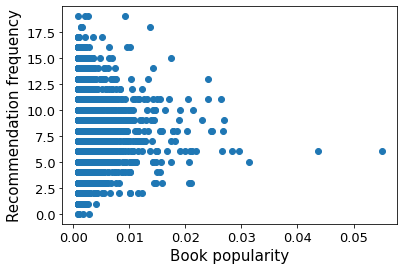

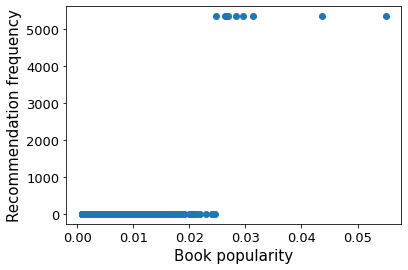

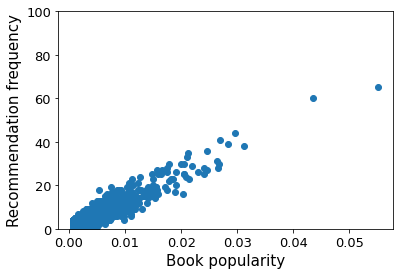

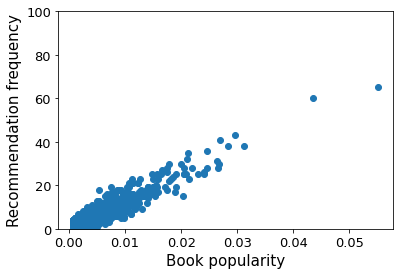

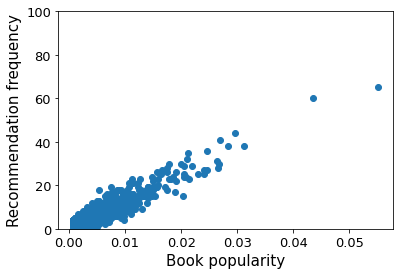

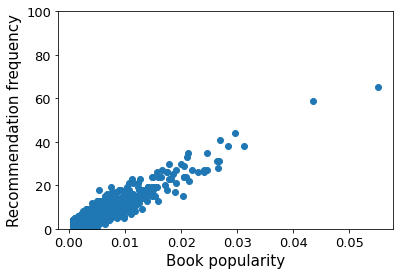

In [16]:
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist['count']
    y = df_item_dist[algo_names[i]]
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    #line = slope * np.array(x) + intercept
    #print(r_value)
    if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
        plt.gca().set_ylim(0, 100)
    plt.plot(x, y, 'o')#, x, line)
    plt.xlabel('Book popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    #plt.savefig('data/ECIR/rec_' + algo_names[i] + '.png', dpi=300, bbox_inches='tight')

In [17]:
# get top items
top_fraction = 0.2
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 1384


In [18]:
# get pop fractions
predict_col = 'bid'
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0
for u, df in df_events.groupby('uid'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 4282
Med count (for check): 1713
High count (for check): 363


In [19]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algos)):
    low_gap_vals.append((low_rec_gap_list[i] - low_gap) / low_gap * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - medium_gap) / medium_gap * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_gap) / high_gap * 100)

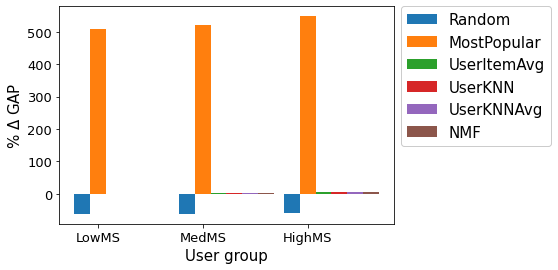

In [20]:
# set width of bar
barWidth = 0.15

# set height of bar
bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]
bars5 = [low_gap_vals[4], medium_gap_vals[4], high_gap_vals[4]]
bars6 = [low_gap_vals[5], medium_gap_vals[5], high_gap_vals[5]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random')
plt.bar(r2, bars2, width=barWidth, label='MostPopular')
plt.bar(r3, bars3, width=barWidth, label='UserItemAvg')
plt.bar(r4, bars4, width=barWidth, label='UserKNN')
plt.bar(r5, bars5, width=barWidth, label='UserKNNAvg')
plt.bar(r6, bars6, width=barWidth, label='NMF')

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='15')
plt.ylabel('% $\Delta$ GAP', fontsize='15')
plt.xticks([r + barWidth for r in range(len(bars1))], ['LowMS', 'MedMS', 'HighMS'], fontsize='13')
plt.yticks(fontsize='13')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='15')
#plt.savefig('data/ECIR/gap_analysis.png', dpi=300, bbox_inches='tight')